In [14]:
import matplotlib.pyplot as p
import numpy as np
%matplotlib inline

In [15]:
import tangos as db
db.init_db('data2.db')

In [16]:
db.all_simulations()[0].timesteps

[<TimeStep 'L0200N0720_HYDRO_FIDUCIAL/flamingo_0000/flamingo_0000.hdf5'>,
 <TimeStep 'L0200N0720_HYDRO_FIDUCIAL/flamingo_0001/flamingo_0001.hdf5' z=1.00 t=2.93 Gyr>,
 <TimeStep 'L0200N0720_HYDRO_FIDUCIAL/flamingo_0002/flamingo_0002.hdf5' z=0.75 t=4.01 Gyr>,
 <TimeStep 'L0200N0720_HYDRO_FIDUCIAL/flamingo_0003/flamingo_0003.hdf5' z=0.50 t=5.73 Gyr>,
 <TimeStep 'L0200N0720_HYDRO_FIDUCIAL/flamingo_0004/flamingo_0004.hdf5' z=0.40 t=6.69 Gyr>,
 <TimeStep 'L0200N0720_HYDRO_FIDUCIAL/flamingo_0005/flamingo_0005.hdf5' z=0.30 t=7.89 Gyr>,
 <TimeStep 'L0200N0720_HYDRO_FIDUCIAL/flamingo_0006/flamingo_0006.hdf5' z=0.20 t=9.39 Gyr>,
 <TimeStep 'L0200N0720_HYDRO_FIDUCIAL/flamingo_0007/flamingo_0007.hdf5' z=0.10 t=11.29 Gyr>,
 <TimeStep 'L0200N0720_HYDRO_FIDUCIAL/flamingo_0008/flamingo_0008.hdf5' z=0.00 t=13.76 Gyr>]

In [17]:
class NoHalosInStackError(ValueError):
    pass

def get_xs(ts, property_name, profile):
    prop = ts.halos[2].get_description(property_name)
    return prop.plot_x_values(profile)
        
def get_labels(ts, property_name):
    prop = ts.halos[2].get_description(property_name)
    ylabs = prop.plot_ylabel()
    xlab = prop.plot_xlabel()
    return xlab, ylabs[prop.index_of_name(property_name)]

def get_stack(property_name, M_min, M_max, use_log=False, timestep_name="L0200%HYDRO%/%8%"):
    ts = db.get_timestep(timestep_name)
    M200m, profiles = ts.calculate_all('M200m()', property_name)
    mask = (M200m>10**M_min)*(M200m<10**M_max)
    num_included = mask.sum()
    if num_included == 0 :
        raise NoHalosInStackError("No halos in stack")
    
    log_profiles = []
    for p in profiles[mask]:
        ln_p = np.log(p)
        ln_p[ln_p==-np.inf] = np.nan
        log_profiles.append(ln_p)
    if 'rho' in property_name:
        # zeros should be counted, otherwise biased mass estimator
        if use_log:
            mean_profile = np.exp(np.nansum([p for p in log_profiles], axis=0)/num_included)
        else:
            mean_profile = np.nansum([p for p in profiles[mask]], axis=0)/num_included
    else:
        # nan bins should not be counted
        if use_log:
            mean_profile = np.exp(np.nanmean([p for p in log_profiles], axis=0))
        else:
            mean_profile = np.nanmean([p for p in profiles[mask]], axis=0)
    err_log_profile = (np.nanstd([p for p in log_profiles], axis=0)/np.sqrt(num_included))

    xs = get_xs(ts, property_name, mean_profile)
    labels = get_labels(ts, property_name)
    return mean_profile, mean_profile * err_log_profile, xs, labels
           

In [18]:
def make_plot(name='rho', M_min=12.5, M_max=13.0, with_guide=False, 
              relative=True, exclusive=False, with_exclusive=False, 
              with_alternative_ts=None, particle='gas',
              get_stack_kwargs={}, 
              plot_kwargs={}, norm_guide=False):
    
    # Determine base property name
    if relative:
        prop_name = f'{name}_r200m_relative'
    else:
        prop_name = name
    if exclusive:
        prop_name += "_exclusive"

    
    if particle == 'ratio':
        # Create gas and dm property names
        gas_prop_name = f'gas_{prop_name}'
        dm_prop_name = f'dm_{prop_name}'
        
        try:
            gas_profile, gas_uncertainty, xs, labels = get_stack(gas_prop_name, M_min, M_max, **get_stack_kwargs)
            dm_profile, dm_uncertainty, _, _ = get_stack(dm_prop_name, M_min, M_max, **get_stack_kwargs)
        except NoHalosInStackError:
            print(f"No halos in stack for {(M_min, M_max)}")
            return 
        
        # Calculate ratio
        profile = gas_profile / dm_profile
        # Propagate uncertainty (assuming independent errors)
        uncertainty = profile * np.sqrt((gas_uncertainty/gas_profile)**2 + (dm_uncertainty/dm_profile)**2)
        
    else:
        prop_name = f'{particle}_{prop_name}'
        
        try:
            profile, uncertainty, xs, labels = get_stack(prop_name, M_min, M_max, **get_stack_kwargs)
        except NoHalosInStackError:
            print(f"No halos in stack for {(M_min, M_max)}")
            return 

    r = 10**xs

    if norm_guide:
        if name == 'entropy':
            pro_ks = (r)**(1.1)
        else:
            pro_ks = (r)**-2
        profile/=pro_ks
        uncertainty /= pro_ks
    

    plot_kwargs = {'label': f"$10^{{{M_min}}} < M_{{200m}} / M_{{\\odot}} < 10^{{{M_max}}}$"} | plot_kwargs
    main_line = p.plot(r, profile, **plot_kwargs)
    p.fill_between(r, profile-uncertainty, profile+uncertainty, alpha=0.2)
    if name == 'vr' or name == 'mdot':
        p.semilogx()
    else:
        p.loglog()

    
    
    if with_guide and not norm_guide:
        if name == 'entropy':
            pro_ks = profile[-10] * (r/r[-10])**(1.1)
            p.plot(r, pro_ks, ':', color='grey', label=r"$\propto r^{1.1}$")
        else:
            pro_rm2 = profile[-10] * (r/r[-10])**-2
            p.plot(r, pro_rm2, ':', color='grey', label=r"$\propto r^{-2}$")
    
    xlabel, ylabel = labels

    p.xlabel(xlabel)

    if norm_guide:
        ylabel = f"$r^{2}$\\, {ylabel}$"
    p.ylabel(ylabel)


    if with_exclusive:
        make_plot(name,M_min,M_max,False,relative,True,
                  plot_kwargs={'color': main_line[0].get_color(),
                               'linestyle': '--', 
                               'label': None},
                  get_stack_kwargs=get_stack_kwargs,
                  norm_guide=norm_guide,
                  particle=particle)
    
    if with_alternative_ts:
        make_plot(name, M_min, M_max, False, relative, exclusive,
                  plot_kwargs={'color': main_line[0].get_color(),
                               'alpha': 0.2,
                               'label': None},
                  get_stack_kwargs= {"timestep_name": "L0100%/%8%"} | get_stack_kwargs,
                  norm_guide=norm_guide,
                  particle=particle
                  )


In [19]:
ranges = [(11.8, 12.2), (12.6, 13.0), (13.0, 13.5), (13.5, 14.0), (14.0, 15.0)]
ranges = [(12.0,12.5), (12.5, 13.0), (13.0, 13.5), (13.5, 14.0), (14.0, 15.0)]
vars = ['density', 'entropy', 'temp', 'p']
plot_guides_for = ['density', 'entropy', 'temp', 'p']

def make_profile_plots(v, tsnum=8, boxsize=200, with_exclusive=True, norm_guide=False, particle='gas'):
    timestep_name = f"L0{boxsize}%HYDRO%/%{tsnum}.hdf5"
    z = db.get_timestep(timestep_name).redshift
    print(f"Plotting {v} profiles for {timestep_name}")
    p.figure(figsize=(12, 5))
    p.subplot(121)
    p.title(f"Relative radius profiles ($z={z:.1f}$)")
    for i, ra in enumerate(ranges):
        with_guide = i == 3 and v in plot_guides_for
        make_plot(v, ra[0], ra[1], with_guide=with_guide, with_exclusive=with_exclusive, relative=True,
                  with_alternative_ts=False, get_stack_kwargs={'timestep_name': timestep_name},
                  norm_guide=norm_guide, particle=particle)
    p.legend()
    p.subplot(122)
    p.title(f"Absolute radius profiles ($z={z:.1f}$)")
    for i, ra in enumerate(ranges):
        with_guide = i == 3 and v in plot_guides_for
        make_plot(v, ra[0], ra[1], with_guide=with_guide, with_exclusive=with_exclusive, relative=False,
                  with_alternative_ts=False, get_stack_kwargs={'timestep_name': timestep_name},
                  norm_guide=norm_guide, particle=particle)

    p.legend()
    
def make_all():
    for v in vars:
        make_profile_plots(v)
        p.savefig(f"{v}_profiles.pdf", bbox_inches='tight')
        p.close()

In [20]:
from matplotlib.colors import LinearSegmentedColormap

# Create a colormap from red to blue with 5 colors
cmap = LinearSegmentedColormap.from_list("blue_red", ["blue", "red"], N=5)
colors = [cmap(i/4) for i in range(5)]

p.rc('axes', prop_cycle=p.cycler('color', colors))

Plotting mass_enclosed_2d profiles for L0200%HYDRO%/%6.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_5667/2075515767.py:24: RuntimeWarning: divide by zero encountered in log
  ln_p = np.log(p)


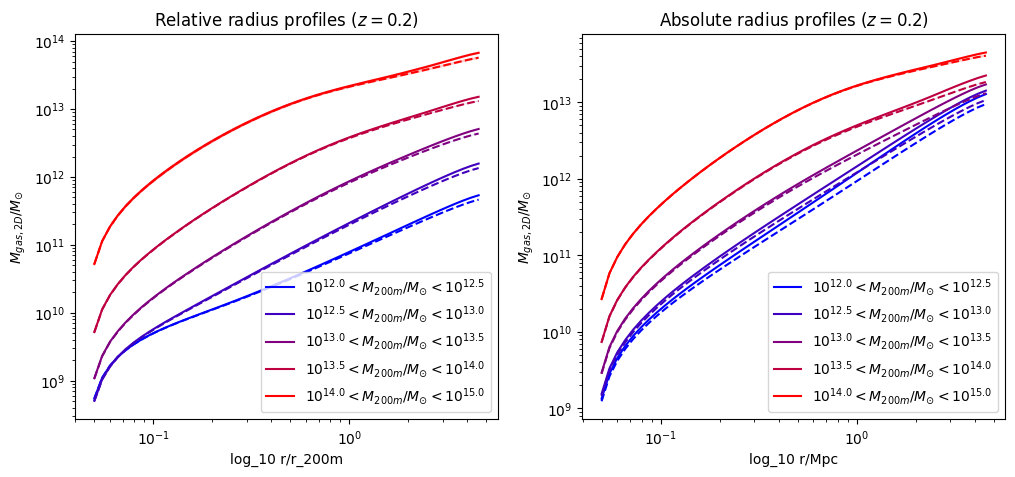

In [21]:
make_profile_plots('mass_enclosed_2d', with_exclusive=True, boxsize=200, tsnum=6)

Plotting vr profiles for L0100%HYDRO%/%8.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_61943/2075515767.py:24: RuntimeWarning: invalid value encountered in log
  ln_p = np.log(p)
/Users/app/Science/flamingo/venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


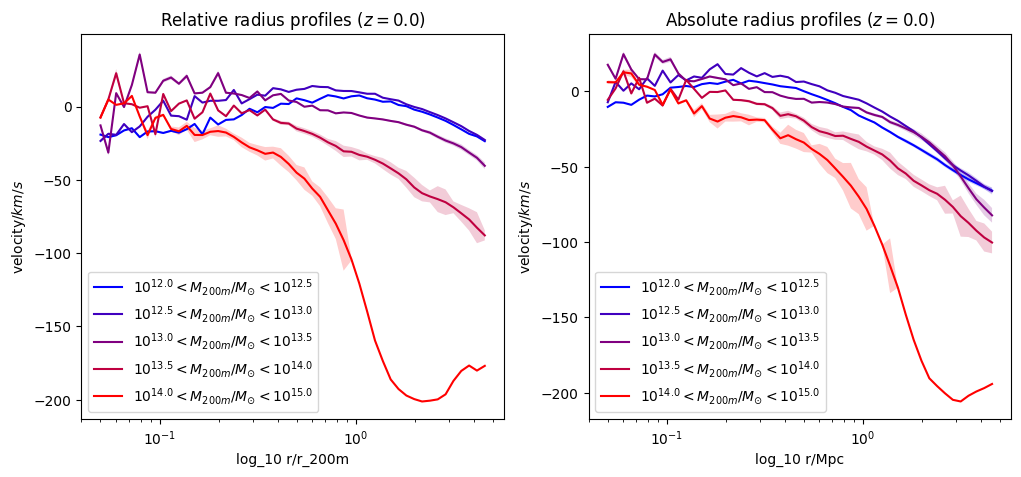

In [9]:
make_profile_plots('vr', particle='gas', with_exclusive=False, boxsize=100)

Plotting mdot profiles for L0100%HYDRO%/%8.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_61943/2075515767.py:24: RuntimeWarning: invalid value encountered in log
  ln_p = np.log(p)


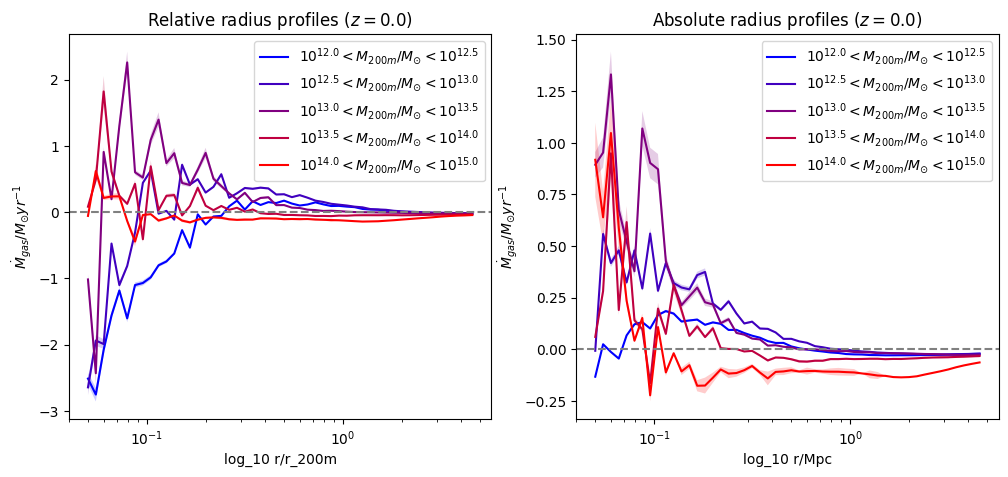

In [11]:
make_profile_plots('mdot', particle='gas', with_exclusive=False, boxsize=100)
p.subplot(121)
p.axhline(0, color='grey', linestyle='--')
p.subplot(122)
p.axhline(0, color='grey', linestyle='--')

Plotting mdot_outflow profiles for L0100%HYDRO%/%8.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_61943/2075515767.py:24: RuntimeWarning: divide by zero encountered in log
  ln_p = np.log(p)


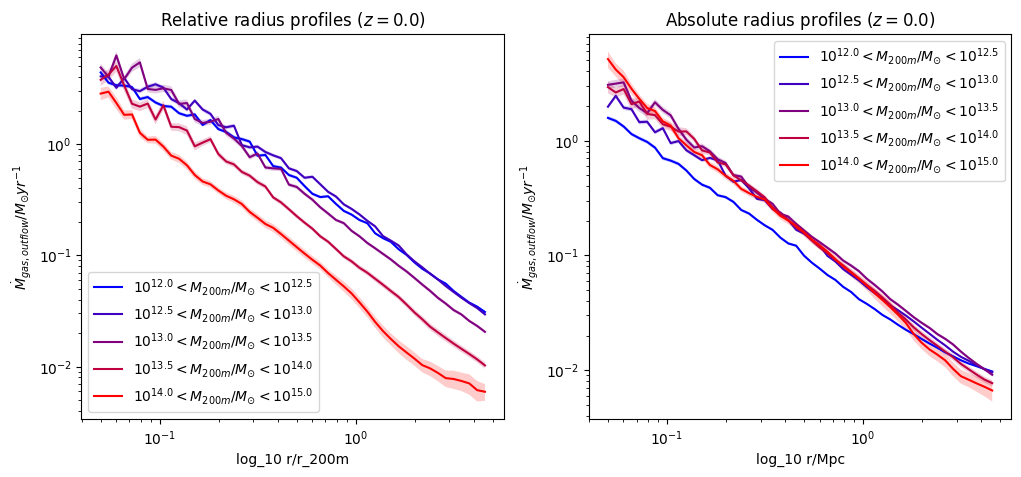

In [12]:
make_profile_plots('mdot_outflow', particle='gas', with_exclusive=False, boxsize=100)

Plotting mdot_inflow profiles for L0100%HYDRO%/%8.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_61943/2075515767.py:24: RuntimeWarning: divide by zero encountered in log
  ln_p = np.log(p)


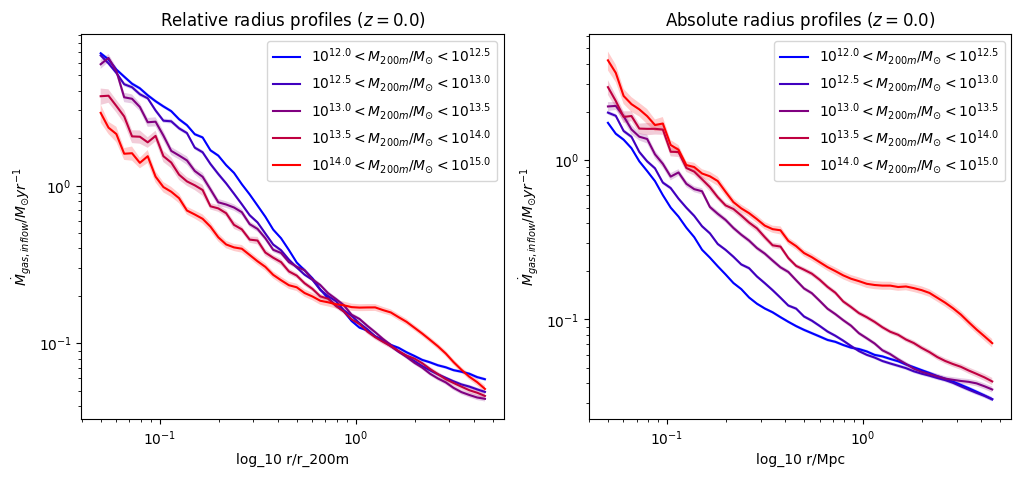

In [13]:
make_profile_plots('mdot_inflow', particle='gas', with_exclusive=False, boxsize=100)

Plotting mdot profiles for L0100%HYDRO%/%8.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_61943/2075515767.py:24: RuntimeWarning: invalid value encountered in log
  ln_p = np.log(p)


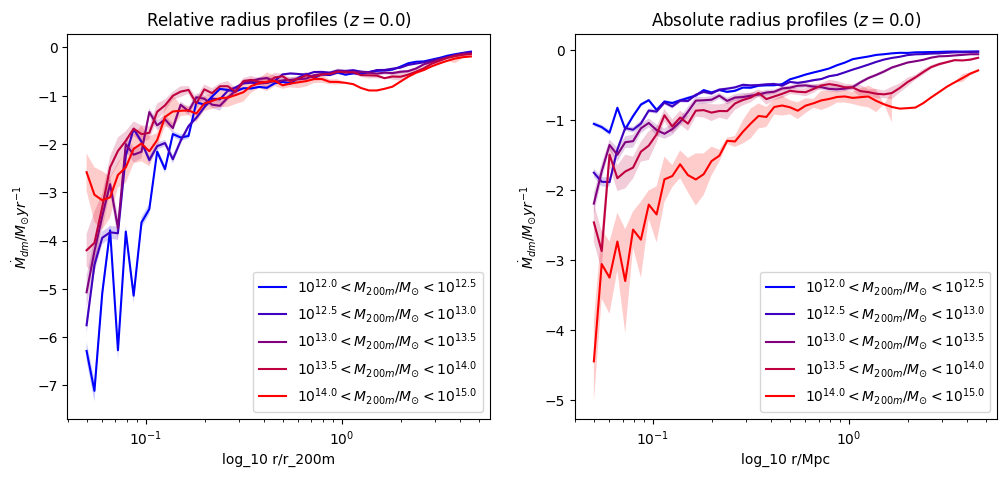

In [14]:
make_profile_plots('mdot', particle='dm', with_exclusive=False, boxsize=100)

Plotting mass_enclosed profiles for L0100%HYDRO%/%8.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_61943/2075515767.py:24: RuntimeWarning: divide by zero encountered in log
  ln_p = np.log(p)


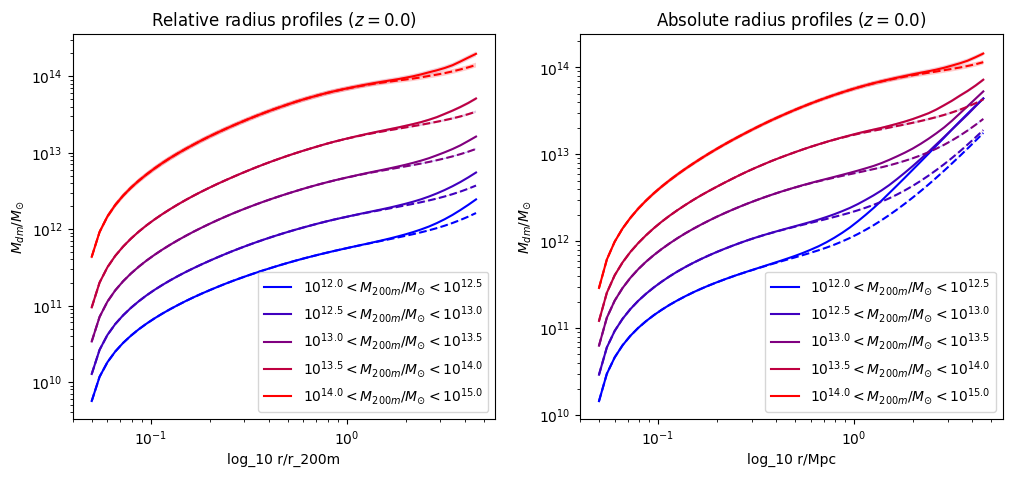

In [16]:
make_profile_plots('mass_enclosed',  particle='dm', with_exclusive=True, boxsize=100)

Plotting mdot profiles for L0100%HYDRO%/%8.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_47628/2075515767.py:24: RuntimeWarning: invalid value encountered in log
  ln_p = np.log(p)


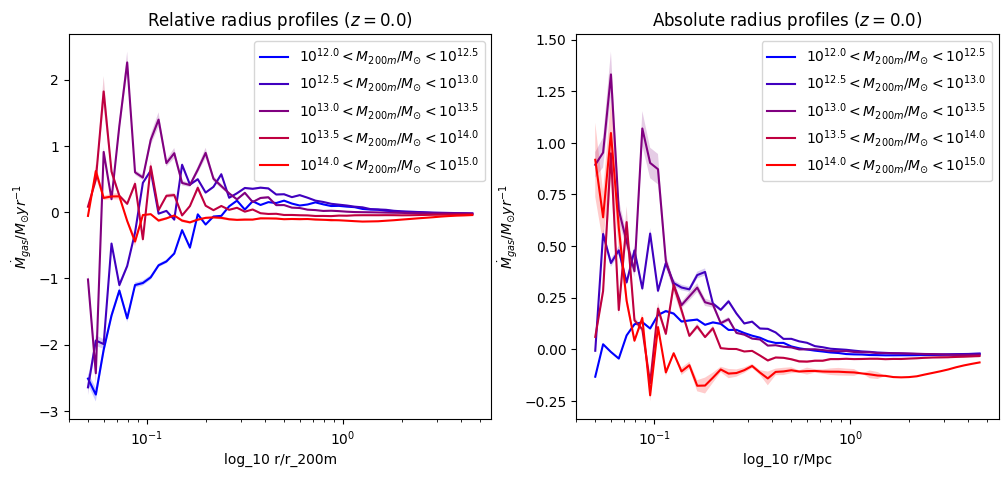

In [21]:
make_profile_plots('mdot', particle='gas', with_exclusive=False, boxsize=100)

Plotting vr profiles for L0100%HYDRO%/%8.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_44449/2075515767.py:24: RuntimeWarning: invalid value encountered in log
  ln_p = np.log(p)


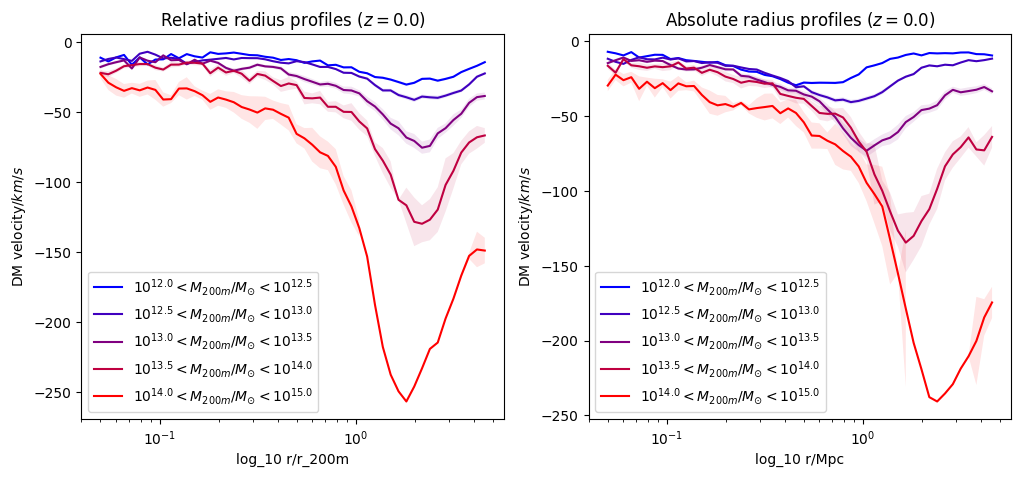

In [21]:
make_profile_plots('vr', particle='dm', with_exclusive=False, boxsize=100)

Plotting mass_enclosed profiles for L0100%HYDRO%/%8.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_44449/2075515767.py:24: RuntimeWarning: divide by zero encountered in log
  ln_p = np.log(p)


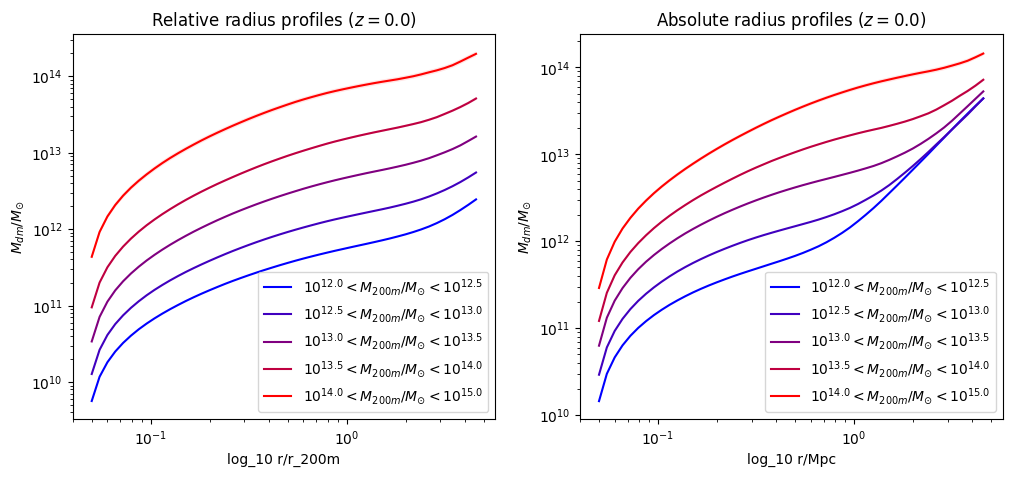

In [22]:
make_profile_plots('mass_enclosed', particle='dm', with_exclusive=False, boxsize=100)

Plotting mass_enclosed profiles for L0100%HYDRO%/%8.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_47628/2075515767.py:24: RuntimeWarning: divide by zero encountered in log
  ln_p = np.log(p)


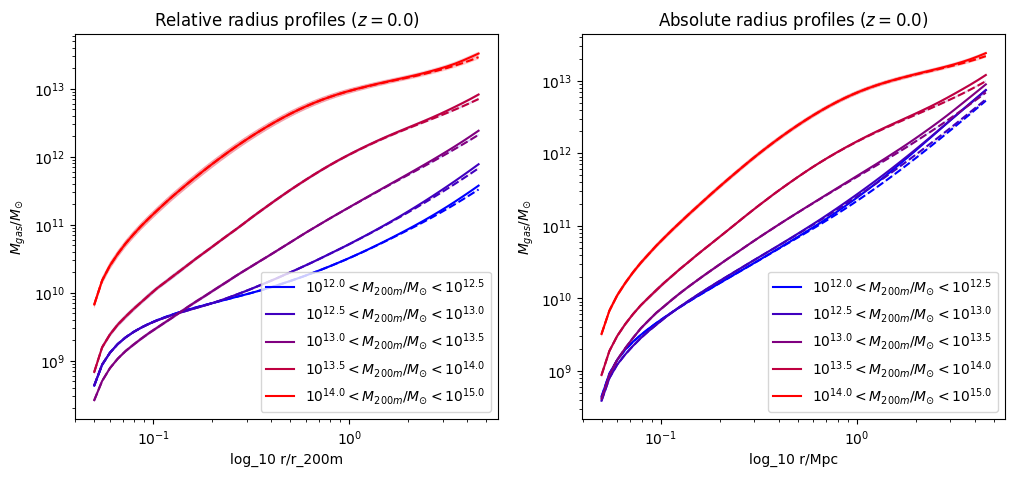

In [22]:
make_profile_plots('mass_enclosed', particle='gas', with_exclusive=True, boxsize=100)

Plotting mass_enclosed profiles for L0100%HYDRO%/%8.hdf5


/var/folders/vk/zg9_2k_512l3syhc8kdzkzwm0000gp/T/ipykernel_44449/2075515767.py:24: RuntimeWarning: divide by zero encountered in log
  ln_p = np.log(p)


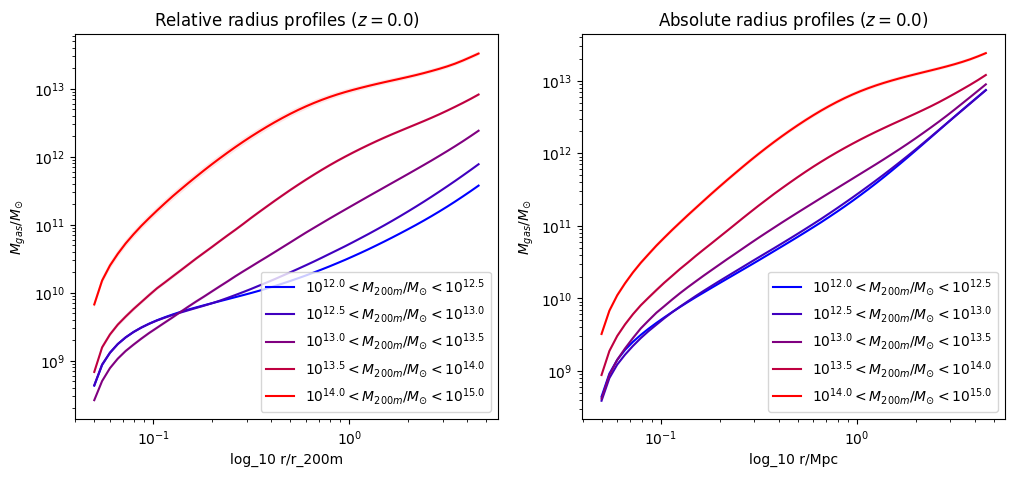

In [23]:
make_profile_plots('mass_enclosed', particle='gas', with_exclusive=False, boxsize=100)

Plotting entropy profiles for L0100%HYDRO%/%8.hdf5


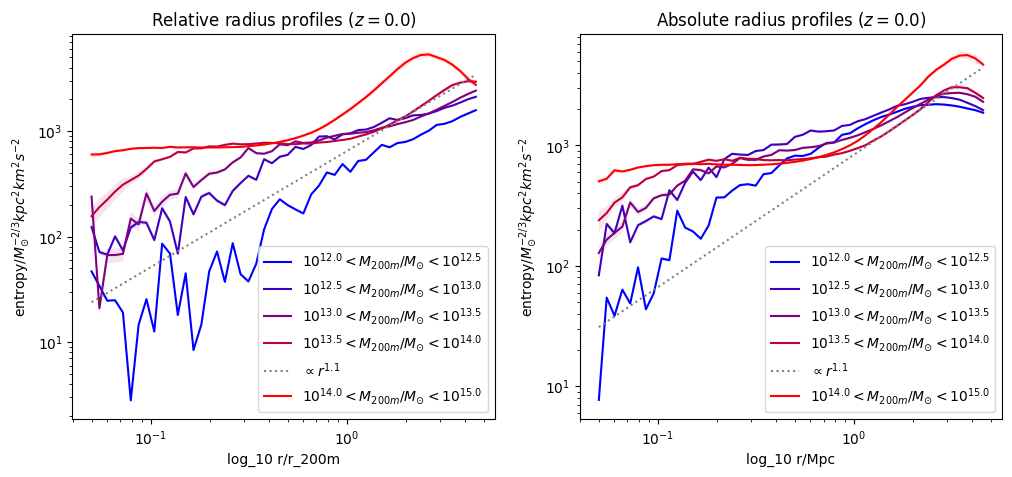

In [28]:
make_profile_plots('entropy', particle='gas', with_exclusive=False, boxsize=100)

Plotting p profiles for L0100%HYDRO%/%8.hdf5


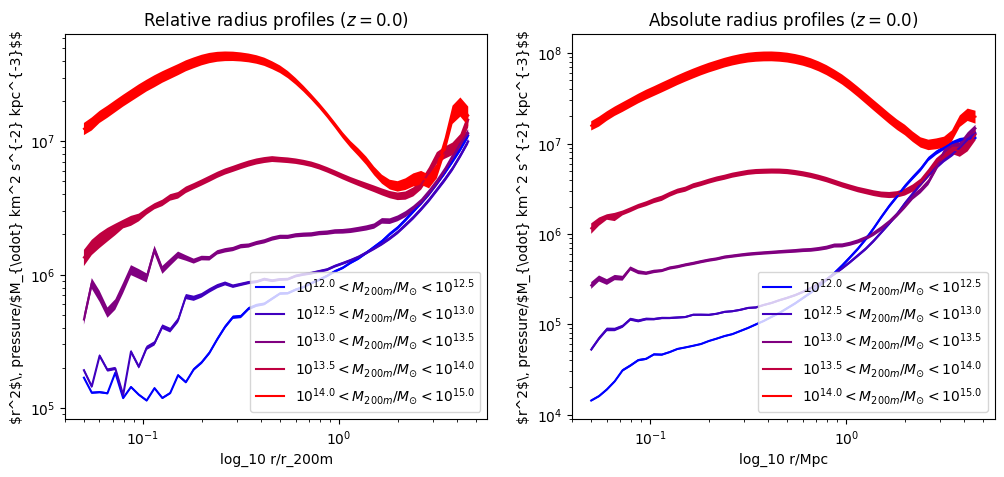

In [36]:
make_profile_plots('p', particle='gas', with_exclusive=False, boxsize=100, norm_guide=True)

Plotting temp profiles for L0100%HYDRO%/%8.hdf5


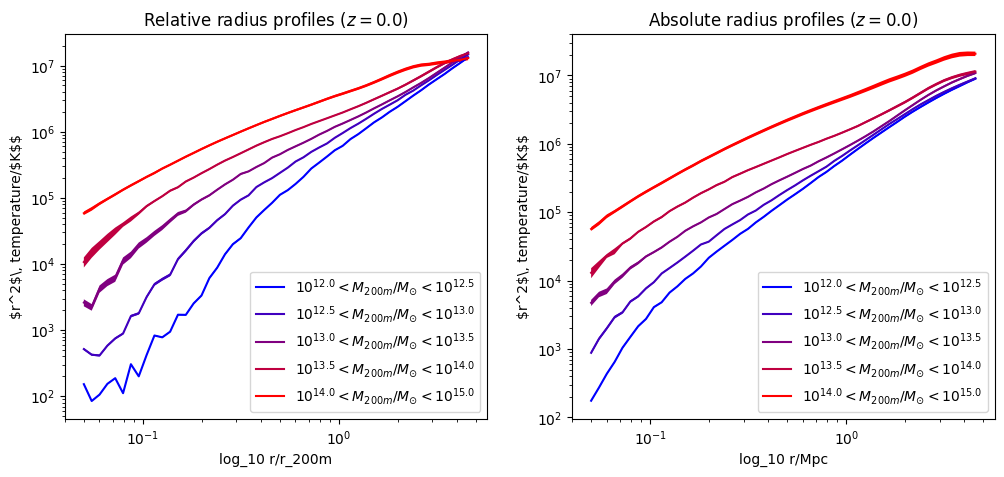

In [38]:
make_profile_plots('temp', particle='gas', with_exclusive=False, boxsize=100, norm_guide=True)

In [67]:
import pynbody 

def dm_gas_plot(radius = 1.0, dm_in_radius=True, cap=False):
    log_radius = np.log10(radius)
    log_cap_radius = log_radius + 0.15
    M200m, gas_mass_enclosed_1Mpc_2d, gas_mass_enclosed_1Mpc_3d, gas_mass_cap_1Mpc_2d, dm_mass_1Mpc_2d  = \
    db.get_timestep("%200N%/%6.hdf5").calculate_all('M200m()', f'at({log_radius},gas_mass_enclosed_2d)', f'at({log_radius},gas_mass_enclosed)',
                                                    f'2*at({log_radius}, gas_mass_enclosed_2d) - at({log_cap_radius}, gas_mass_enclosed_2d)',
                                                    f'at({log_radius}, dm_mass_enclosed_2d)')

    
    if dm_in_radius:
        M_dm = dm_mass_1Mpc_2d
    else:
        M_dm = M200m

    if cap:
        p.plot(M_dm, gas_mass_cap_1Mpc_2d, '.', label="CAP 2D", color='red', alpha=0.02)
    else:
        p.plot(M_dm, gas_mass_enclosed_1Mpc_2d, '.', label="Non-CAP 2D", color='blue', alpha=0.02)
        
    p.plot([1e12,1e16], [1e11, 1e15], 'k:', label="10%")
    p.xlim(5e12, 1e16)
    p.ylim(2e10, 5e14)
    p.legend()
    p.loglog()
    p.ylabel(f"Gas mass ({radius} Mpc) / M$_{{\\odot}}$")

    if dm_in_radius:
        p.xlabel(f"DM mass ({radius} Mpc) / M$_{{\\odot}}$")
    else:
        p.xlabel(f"M$_{{200}}$ / M$_{{\\odot}}$")
    p.title("Flamingo L200m9")


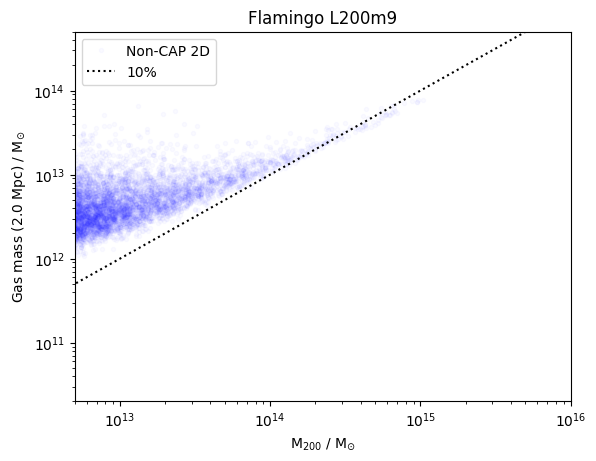

In [68]:
dm_gas_plot(2.0,dm_in_radius=False)

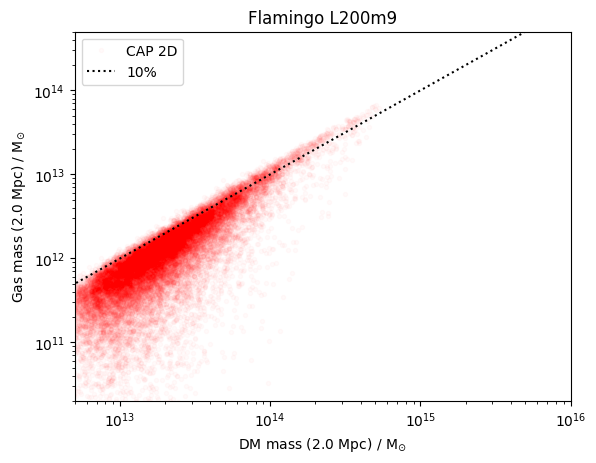

In [69]:
dm_gas_plot(2.0, dm_in_radius=True, cap = True)

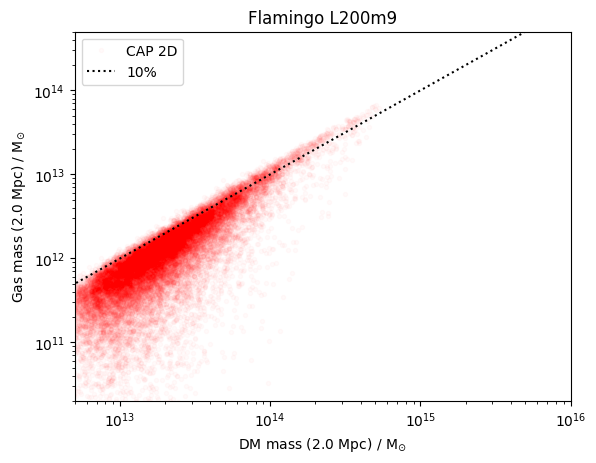

In [70]:
dm_gas_plot(2.0, dm_in_radius=True, cap = True)

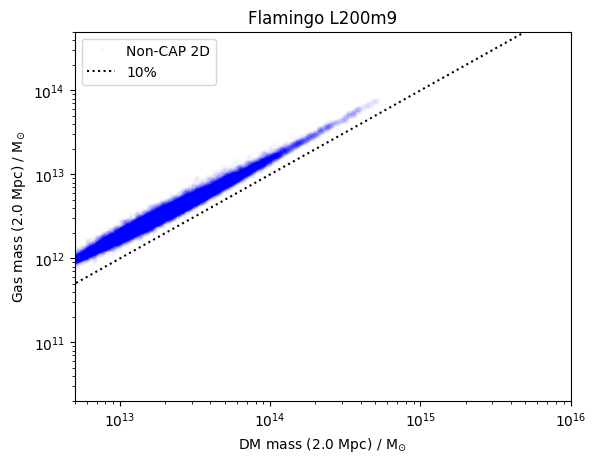

In [74]:
dm_gas_plot(2.0, dm_in_radius=True, cap = False)

In [39]:
M200m, fgas_profile  = \
    db.get_timestep("%100N%/%8.hdf5").calculate_all('M200m()', f'gas_mass_enclosed/dm_mass_enclosed')

In [41]:
mask = (M200m > 1e13) * (M200m < 1.1e13)

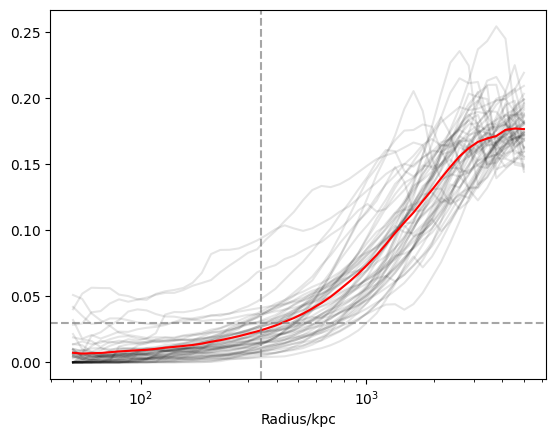

In [ ]:
radius_of_profile = np.logspace(np.log10(50.0), np.log10(5000.0), len(fgas_profile[mask].T)) 
p.plot(radius_of_profile, fgas_profile[mask].T,"k", alpha=0.1)
p.plot(radius_of_profile, np.mean(fgas_profile[mask], axis=0), "r")

p.xlabel("Radius/kpc")
p.semilogx()

p.axvline(340, color='gray', linestyle='--', alpha=0.7)
p.axhline(0.03, color='gray', linestyle='--', alpha=0.7)